
# 04 — Fine-tuning **XLNet** for Crisis Tweets Classification

- **Цель и задача**. Бинарная классификация твитов на «Related & informative» vs «Not informative» для кризисных событий. Модель должна обобщать на ранее невидимый тестовый набор.

- **Стек**. PyTorch + Transformers (XLNet-base-cased), sklearn для метрик, NumPy/Pandas, Matplotlib; отслеживание экспериментов и артефактов — MLflow (локальный трекинг).

- **Пайплайн данных**. Чёткое разделение train / val / test (стратифицированное). Токенизация XLNet-токенизатором с max_length и padding/truncation. Имбаланс классов компенсируется взвешенной CrossEntropy.

- **Обучение**. Тренировка на train с AdamW и линейным шедулером с warmup, смешанная точность (AMP). Лучшая модель выбирается по минимальному val_loss (чекпойнт). Порог для класса подбирается по val для максимума F1.

- **Оценка и логирование**. На test считаются Accuracy / Precision / Recall / F1 / ROC-AUC + матрица ошибок и ROC-кривая. В MLflow пишутся параметры, метрики, графики (accuracy/loss, ROC) и сохранённая PyTorch-модель.

In [ ]:
!pip -q install transformers mlflow accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 77.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 329.1/329.1 kB 26.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.2/86.2 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.4/718.4 kB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.6/106.6 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.4/96.4 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.4/

In [ ]:
import os, re, random, pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc, classification_report
)

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup
)

import mlflow
import mlflow.pytorch

def set_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seeds(42)

BASE_DIR = os.getcwd()
TRACKING_DIR = os.path.join(BASE_DIR, "mlruns")
os.makedirs(TRACKING_DIR, exist_ok=True)
mlflow.set_tracking_uri(pathlib.Path(TRACKING_DIR).absolute().as_uri())
mlflow.set_experiment("XLNet_Finetune")
print("MLflow tracking:", mlflow.get_tracking_uri())

2025/10/07 14:35:40 INFO mlflow.tracking.fluent: Experiment with name 'XLNet_Finetune' does not exist. Creating a new experiment.


MLflow tracking: file:///content/mlruns


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

DATA_DIR = "/content/drive/MyDrive/crisis_lstm"
CAT = "ALL"

def _cname(x): return re.sub(r'[^A-Za-z0-9_]+','_', str(x))

if CAT == "ALL":
    train_path = f"{DATA_DIR}/train_data.csv"
    test_path  = f"{DATA_DIR}/test_data.csv"
else:
    cname = _cname(CAT)
    train_path = f"{DATA_DIR}/train_{cname}.csv"
    test_path  = f"{DATA_DIR}/test_{cname}.csv"

df_train = pd.read_csv(train_path)
df_test  = pd.read_csv(test_path)

assert {'text','label'}.issubset(df_train.columns)
assert {'text','label'}.issubset(df_test.columns)
print('Loaded:', train_path, df_train.shape, '|', test_path, df_test.shape)
print('Train positive ratio:', round(df_train['label'].mean(), 3))

Mounted at /content/drive
Loaded: /content/drive/MyDrive/crisis_lstm/train_data.csv (19835, 2) | /content/drive/MyDrive/crisis_lstm/test_data.csv (4959, 2)
Train positive ratio: 0.605


In [ ]:
# --- Create split from the loaded TRAIN (stratified) ---

df_tr, df_dev = train_test_split(
    df_train, test_size=0.15, stratify=df_train['label'], random_state=42
)

print("DEV split:", df_tr.shape, df_dev.shape, "| TEST:", df_test.shape if 'df_test' in globals() else None)

DEV split: (16859, 2) (2976, 2) | TEST: (4959, 2)


In [ ]:
MODEL_NAME = "xlnet-base-cased"
MAX_LEN = 160
BATCH_SIZE = 16

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

class TweetsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = list(texts)
        self.labels = np.array(labels, dtype=np.int64)
        self.tok = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tok(
            str(self.texts[idx]),
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt",
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_ds = TweetsDataset(df_tr["text"],  df_tr["label"],  tokenizer, MAX_LEN)
dev_ds   = TweetsDataset(df_dev["text"], df_dev["label"], tokenizer, MAX_LEN)
test_ds  = TweetsDataset(df_test["text"], df_test["label"], tokenizer, MAX_LEN)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
dev_loader   = DataLoader(dev_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

batches: train=1054 | dev=186 | test=310


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_labels = 2
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=num_labels
).to(device)

pos_ratio = float(df_train["label"].mean())
w1 = 1.0 / max(pos_ratio, 1e-6)
w0 = 1.0 / max(1.0 - pos_ratio, 1e-6)
class_weights = torch.tensor([w0, w1], dtype=torch.float32, device=device)

criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.03)
# criterion = nn.CrossEntropyLoss(weight=class_weights)

LR = 1e-5
EPOCHS = 3

no_decay = ["bias", "LayerNorm.weight", "LayerNorm.bias"]
optimizer_grouped_parameters = [
    {
        "params": [
            p for n, p in model.named_parameters()
            if not any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.01,
    },
    {
        "params": [
            p for n, p in model.named_parameters()
            if any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.0,
    },
]
optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr=LR)

num_training_steps = EPOCHS * len(train_loader)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * num_training_steps),
    num_training_steps=num_training_steps,
)

scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

print("Device:", device)

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Device: cuda
Train batches per epoch: 1054  |  steps total: 3162


/tmp/ipython-input-3994584356.py:47: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())


In [ ]:
def train_epoch(model, loader, optimizer, scheduler, scaler, device):
    model.train()
    total_loss, total, correct = 0.0, 0, 0
    for batch in loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        labels = batch.pop("labels")
        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(device=='cuda')):
            outputs = model(**batch, labels=None)
            logits = outputs.logits
            loss = criterion(logits, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        total_loss += loss.item() * labels.size(0)
        preds = logits.argmax(dim=-1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return total_loss / max(1,total), correct / max(1,total)

@torch.no_grad()
def eval_epoch(model, loader, device):
    model.eval()
    total_loss, total, correct = 0.0, 0, 0
    all_probs, all_labels = [], []
    for batch in loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        labels = batch.pop("labels")
        outputs = model(**batch, labels=None)
        logits = outputs.logits
        loss = criterion(logits, labels)

        total_loss += loss.item() * labels.size(0)
        probs = torch.softmax(logits, dim=-1)[:, 1]
        preds = logits.argmax(dim=-1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)
        all_probs.append(probs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

    y_prob = np.concatenate(all_probs)
    y_true = np.concatenate(all_labels)

    fpr, tpr, _ = roc_curve(y_true, y_prob, pos_label=1)
    mauc = auc(fpr, tpr)
    acc = correct / max(1,total)
    return total_loss / max(1,total), acc, y_true, y_prob, (fpr, tpr, mauc)

def log_metrics(y_true, y_prob, mlflow_client=None, prefix="test"):
    y_bin = (y_prob > 0.5).astype(int)
    acc  = accuracy_score(y_true, y_bin)
    pre  = precision_score(y_true, y_bin, zero_division=0)
    rec  = recall_score(y_true, y_bin, zero_division=0)
    f1   = f1_score(y_true, y_bin, zero_division=0)
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    mauc = auc(fpr, tpr)
    print(classification_report(
        y_true, y_bin,
        target_names=['Not informative','Related and informative']
    ))
    if mlflow_client:
        mlflow.log_metric(f"{prefix}_accuracy",  float(acc))
        mlflow.log_metric(f"{prefix}_precision", float(pre))
        mlflow.log_metric(f"{prefix}_recall",    float(rec))
        mlflow.log_metric(f"{prefix}_f1",        float(f1))
        mlflow.log_metric(f"{prefix}_mAUC",      float(mauc))
    return acc, pre, rec, f1, mauc

/tmp/ipython-input-2182925284.py:8: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


[1/3] train_loss=0.4754 acc=0.7823 | val_loss=0.3796 acc=0.8451 AUC=0.9263


/tmp/ipython-input-2182925284.py:8: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


[2/3] train_loss=0.3707 acc=0.8525 | val_loss=0.3709 acc=0.8579 AUC=0.9313


/tmp/ipython-input-2182925284.py:8: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


[3/3] train_loss=0.3232 acc=0.8802 | val_loss=0.3791 acc=0.8609 AUC=0.9322


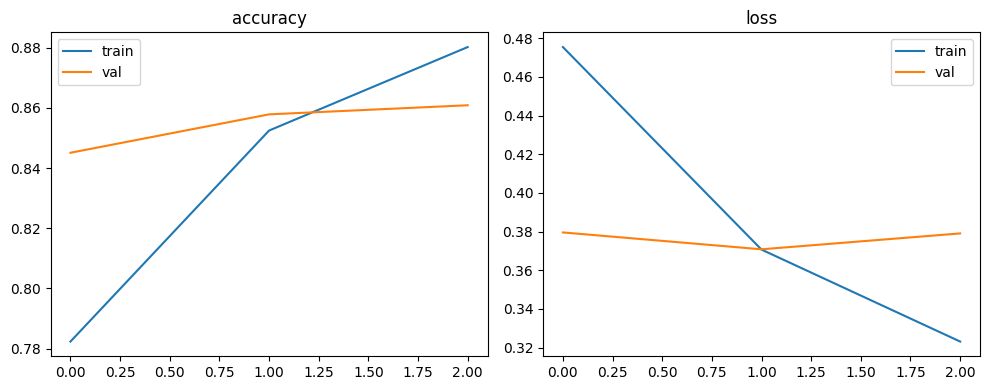

                         precision    recall  f1-score   support

        Not informative       0.80      0.85      0.82      1961
Related and informative       0.90      0.86      0.88      2998

               accuracy                           0.86      4959
              macro avg       0.85      0.85      0.85      4959
           weighted avg       0.86      0.86      0.86      4959



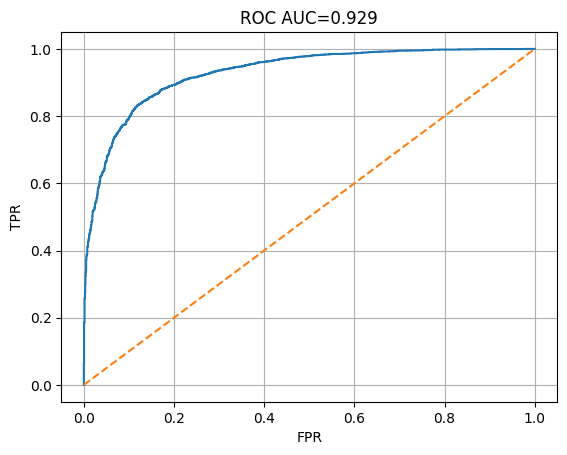

2025/10/07 15:22:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/07 15:22:40 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/10/07 15:23:03 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.23.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torchvision==0.23.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/10/07 15:23:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example`

In [ ]:
run_name = f"XLNet_{CAT}_bs{BATCH_SIZE}_ep{EPOCHS}_maxlen{MAX_LEN}"
with mlflow.start_run(run_name=run_name):
    mlflow.log_params({
        "model_name": MODEL_NAME,
        "category": CAT,
        "max_len": MAX_LEN,
        "batch_size": BATCH_SIZE,
        "epochs": EPOCHS,
        "lr": LR,
        "weight_decay": 0.01
    })

    hist = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

    # выбираем лучший чекпойнт по минимальному val_loss
    best_val_loss = float("inf")
    best_state = None

    for ep in range(1, EPOCHS + 1):
        tr_loss, tr_acc = train_epoch(model, train_loader, optimizer, scheduler, scaler, device)

        val_loss, val_acc, y_true_val, y_prob_val, (fpr, tpr, mauc_val) = eval_epoch(
            model, dev_loader, device
        )

        hist["train_loss"].append(tr_loss); hist["train_acc"].append(tr_acc)
        hist["val_loss"].append(val_loss);   hist["val_acc"].append(val_acc)

        print(f"[{ep}/{EPOCHS}] "
              f"train_loss={tr_loss:.4f} acc={tr_acc:.4f} | "
              f"val_loss={val_loss:.4f} acc={val_acc:.4f} AUC={mauc_val:.4f}")

        mlflow.log_metrics({
            "train_loss": tr_loss, "train_acc": tr_acc,
            "val_loss": val_loss, "val_acc": val_acc, "val_mAUC": mauc_val
        }, step=ep)

        # сохраняем лучший по val_loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

    # кривые обучения
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].plot(hist["train_acc"], label="train"); ax[0].plot(hist["val_acc"], label="val")
    ax[0].set_title("accuracy"); ax[0].legend()
    ax[1].plot(hist["train_loss"], label="train"); ax[1].plot(hist["val_loss"], label="val")
    ax[1].set_title("loss"); ax[1].legend()
    plt.tight_layout(); plt.show()
    mlflow.log_figure(fig, "training_curves.png")

    # перед тестом — возвращаем лучшие веса по DEV
    if best_state is not None:
        model.load_state_dict(best_state)

    # финальная оценка на TEST (модель раньше его не видела)
    test_loss, test_acc, y_true, y_prob, (fpr, tpr, mauc) = eval_epoch(model, test_loader, device)
    acc, pre, rec, f1, mauc = log_metrics(y_true, y_prob, mlflow, prefix="test")

    # ROC кривая
    fig = plt.figure()
    plt.plot(fpr, tpr); plt.plot([0, 1], [0, 1], '--')
    plt.title(f'ROC AUC={mauc:.3f}')
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.grid(True)
    plt.show()
    mlflow.log_figure(fig, "roc_curve.png")

    # лог модели в MLflow (без input_example/ signature, чтобы не падало)
    mlflow.pytorch.log_model(model, artifact_path="XLNet_model")